# Computer Vision

&copy; 李浩东 haodongli@zju.edu.cn

- Multiscale Object Detection
- Single Shot Multibox Detection (SSD) 
- Region-based CNNs (R-CNNs)
- YOLOv5 for Autonomous Driving
- Semantic Segmentation and the Dataset
- Fully Convolutional Networks

![yolo_simplified.png](./images/8/yolo_simplified.png)


## Multiscale Object Detection

- When using smaller anchor boxes to detect smaller objects, we can sample more regions, while for larger objects we can sample fewer regions.


In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
from torch.nn import functional as F
from torch import nn

img = d2l.plt.imread('./images/8/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

In [2]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


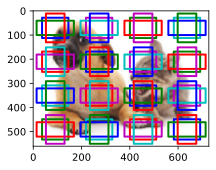

In [3]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

In [4]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [5]:
#@save
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [6]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [7]:
#@save
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [8]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

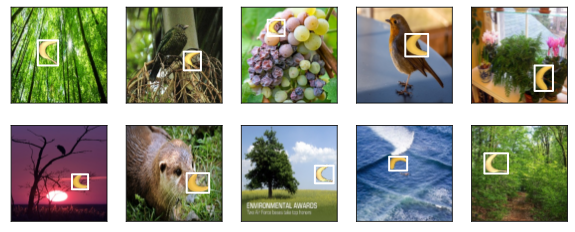

In [9]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Single Shot Multibox Detection

- an object detection model: single shot multibox detection (SSD) (Liu et al., 2016)

[Liu et al., 2016] Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C.-Y., & Berg, A. C. (2016). Ssd: single shot multibox detector. European conference on computer vision (pp. 21–37).

![ssd.svg](./images/8/ssd.svg)


### Class Prediction Layer

In [10]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### Bounding Box Prediction Layer

In [11]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### Concatenating Predictions for Multiple Scales

In [12]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [13]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### Downsampling Block

In [14]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Base Network Block

In [15]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### The Complete Model

In [16]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [17]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [18]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


### Training

In [19]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [20]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### Defining Loss and Evaluation Functions

In [21]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [22]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.46e-03, bbox mae 3.50e-03
7161.5 examples/sec on cuda:0


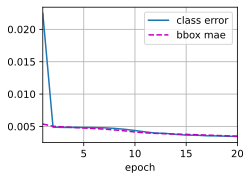

In [23]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

### Prediction

In [25]:
X = torchvision.io.read_image('./images/8/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [26]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

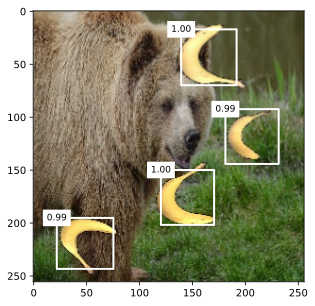

In [27]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

## Region-based CNNs (R-CNNs)

- The R-CNN (Girshick et al., 2014) first extracts many (e.g., 2000) region proposals from the input image (e.g., anchor boxes can also be considered as region proposals), labeling their classes and bounding boxes (e.g., offsets).
- Then a CNN is used to perform forward propagation on each region proposal to extract its features. Next, features of each region proposal are used for predicting the class and bounding box of this region proposal.

![r-cnn.svg](./images/8/r-cnn.svg)

[Girshick et al., 2014] Girshick, R., Donahue, J., Darrell, T., & Malik, J. (2014). Rich feature hierarchies for accurate object detection and semantic segmentation. Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 580–587).

- More concretely, the R-CNN consists of the following four steps:

1. Perform selective search to extract multiple high-quality region proposals on the input image (Uijlings et al., 2013). These proposed regions are usually selected at multiple scales with different shapes and sizes. Each region proposal will be labeled with a class and a ground-truth bounding box.

2. Choose a pretrained CNN and truncate it before the output layer. Resize each region proposal to the input size required by the network, and output the extracted features for the region proposal through forward propagation.

3. Take the extracted features and labeled class of each region proposal as an example. Train multiple support vector machines to classify objects, where each support vector machine individually determines whether the example contains a specific class.

4. Take the extracted features and labeled bounding box of each region proposal as an example. Train a linear regression model to predict the ground-truth bounding box.

### Fast R-CNN

- The main performance bottleneck of an R-CNN lies in the independent CNN forward propagation for each region proposal, without sharing computation. Since these regions usually have overlaps, independent feature extractions lead to much repeated computation. One of the major improvements of the fast R-CNN from the R-CNN is that the CNN forward propagation is only performed on the entire image (Girshick, 2015).

![fast-rcnn.svg](./images/8/fast-rcnn.svg)

[Girshick, 2015] Girshick, R. (2015). Fast r-cnn. Proceedings of the IEEE international conference on computer vision (pp. 1440–1448).

- Its major computations are as follows:


1. Compared with the R-CNN, in the fast R-CNN the input of the CNN for feature extraction is the entire image, rather than individual region proposals. Moreover, this CNN is trainable. Given an input image, let the shape of the CNN output be $1 \times c \times h_1  \times w_1$.
2. Suppose that selective search generates $n$ region proposals. These region proposals (of different shapes) mark regions of interest (of different shapes) on the CNN output. Then these regions of interest further extract features of the same shape (say height $h_2$ and width $w_2$ are specified) in order to be easily concatenated. To achieve this, the fast R-CNN introduces the *region of interest (RoI) pooling* layer: the CNN output and region proposals are input into this layer, outputting concatenated features of shape $n \times c \times h_2 \times w_2$ that are further extracted for all the region proposals.
3. Using a fully connected layer, transform the concatenated features into an output of shape $n \times d$, where $d$ depends on the model design.
4. Predict the class and bounding box for each of the $n$ region proposals. More concretely, in class and bounding box prediction, transform the fully connected layer output into an output of shape $n \times q$ ($q$ is the number of classes) and an output of shape $n \times 4$, respectively. The class prediction uses softmax regression.



- The region of interest pooling layer proposed in the fast R-CNN is different from the pooling layer.
- As an illustrative example, the upper-left $3\times 3$ region of interest is selected on a $4 \times 4$ input. For this region of interest, we use a $2\times 2$ region of interest pooling layer to obtain a $2\times 2$ output. Note that each of the four divided subwindows contains elements 0, 1, 4, and 5 (5 is the maximum); 2 and 6 (6 is the maximum); 8 and 9 (9 is the maximum); and 10.

![roi.svg](./images/8/roi.svg)


### Faster R-CNN

- To be more accurate in object detection, the fast R-CNN model usually has to generate a lot of region proposals in selective search. To reduce region proposals without loss of accuracy, the faster R-CNN proposes to replace selective search with a region proposal network (Ren et al., 2015).

![faster-rcnn.svg](./images/8/faster-rcnn.svg)

[Ren et al., 2015] Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster r-cnn: towards real-time object detection with region proposal networks. Advances in neural information processing systems (pp. 91–99).

- Compared with the fast R-CNN, the faster R-CNN only changes the region proposal method from selective search to a region proposal network. The rest of the model remain unchanged. The region proposal network works in the following steps:

1. Use a $3\times 3$ convolutional layer with padding of 1 to transform the CNN output to a new output with $c$ channels. In this way, each unit along the spatial dimensions of the CNN-extracted feature maps gets a new feature vector of length $c$.
1. Centered on each pixel of the feature maps, generate multiple anchor boxes of different scales and aspect ratios and label them.
1. Using the length-$c$ feature vector at the center of each anchor box, predict the binary class (background or objects) and bounding box for this anchor box.
1. Consider those predicted bounding boxes whose  predicted classes are objects. Remove overlapped results using non-maximum suppression. The remaining  predicted bounding boxes for objects are the region proposals required by the region of interest pooling layer.


### Mask R-CNN

- In the training dataset, if pixel-level positions of object are also labeled on images, the *mask R-CNN* can effectively leverage such detailed labels to further improve the accuracy of object detection (He et al., 2017).

![mask-rcnn.svg](./images/8/mask-rcnn.svg)

- Specifically, the mask R-CNN replaces the region of interest pooling layer with the *region of interest (RoI) alignment layer*. This region of interest alignment layer uses bilinear interpolation to preserve the spatial information on the feature maps, which is more suitable for pixel-level prediction. The output of this layer contains feature maps of the same shape for all the regions of interest. They are used to predict not only the class and bounding box for each region of interest, but also the pixel-level position of the object through an additional fully convolutional network.

[He et al., 2017a] He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask r-cnn. Proceedings of the IEEE international conference on computer vision (pp. 2961–2969).


## YOLOv5 for Autonomous Driving

- [YouTube Video](https://www.youtube.com/watch?v=LXLpXvrR5RI)
- [coLab Link](https://colab.research.google.com/drive/142tXBV8W9wjXhWhOcSOHrFLr83zwL0OA?usp=sharing)
- [Dataset](https://public.roboflow.com/)
- Offical YOLO: [Video Link](https://user-images.githubusercontent.com/67775090/170675096-a4093f14-28ca-450c-a963-88a13584c7b1.mp4)
- Our YOLO: [Video Link](https://user-images.githubusercontent.com/67775090/170675167-cdee08ec-4641-4521-ae80-4649ea24c285.mp4)


| Metric    | Definition                                      |
| --------- | :---------------------------------------------- |
| Precision | The proportion of true positives, or correct predictions, among all positive predictions made by the model.  |
| Recall    | The proportion of true positives among all actual positive instances in the data.   |
| F1 Score  | The harmonic mean of precision and recall.        |
| Confidence| The level of certainty or probability of a prediction.|
|mAP-0.5 |The mean average precision at a intersection over union (IoU) threshold of 0.5. |
|mAP-0.5:0.95|The mean average precision over a range of IoU thresholds, specifically from 0.5 to 0.95 in increments of 0.05. A higher mAP-0.5:0.95 score indicates a better performance of the model at detecting objects across a wide range of IoU thresholds.|

![labels](./images/8/yolov5/labels.jpg)

![labels](./images/8/yolov5/confusion_matrix.png)

![labels](./images/8/yolov5/P_curve.png)

![labels](./images/8/yolov5/R_curve.png)

![labels](./images/8/yolov5/PR_curve.png)

![labels](./images/8/yolov5/F1_curve.png)

<table>
  <tr>
    <td><center><b>box_loss</b></center></td>
     <td><center><b>cls_loss</b></center></td>
  </tr>
  <tr>
    <td><img src="./images/8/yolov5/box_loss.png" width=500 ></td>
    <td><img src="./images/8/yolov5/cls_loss.png" width=500 ></td>
  </tr>
  <tr>
    <td><center><b>obj_loss</b></center></td>
     <td><center><b>precision, recall, and mAP</b></center></td>
  </tr>
  <tr>
    <td><img src="./images/8/yolov5/obj_loss.png" width=500 ></td>
    <td><img src="./images/8/yolov5/map.png" width=500 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Labels</b></center></td>
     <td><center><b>Prediction</b></center></td>
  </tr>
  <tr>
    <td><img src="./images/8/yolov5/val_batch0_labels.jpg" width=500 ></td>
    <td><img src="./images/8/yolov5/val_batch0_pred.jpg" width=500 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Labels</b></center></td>
     <td><center><b>Prediction</b></center></td>
  </tr>
  <tr>
    <td><img src="./images/8/yolov5/val_batch1_labels.jpg" width=500 ></td>
    <td><img src="./images/8/yolov5/val_batch1_pred.jpg" width=500 ></td>
  </tr>
 </table>

<table>
  <tr>
    <td><center><b>Labels</b></center></td>
     <td><center><b>Prediction</b></center></td>
  </tr>
  <tr>
    <td><img src="./images/8/yolov5/val_batch2_labels.jpg" width=500 ></td>
    <td><img src="./images/8/yolov5/val_batch2_pred.jpg" width=500 ></td>
  </tr>
 </table>

## Semantic Segmentation and the Dataset

![segmentation.svg](./images/8/segmentation.svg)

- This section will discuss the problem of *semantic segmentation*, which focuses on how to divide an image into regions belonging to different semantic classes. Different from object detection, semantic segmentation recognizes and understands what are in images in pixel level: its labeling and prediction of semantic regions are in pixel level.


### Image Segmentation and Instance Segmentation

* *Image segmentation* divides an image into several constituent regions. The methods for this type of problem usually make use of the correlation between pixels in the image. It does not need label information about image pixels during training, and it cannot guarantee that the segmented regions will have the semantics that we hope to obtain during prediction. Taking the image as input, image segmentation may divide the dog into two regions: one covers the mouth and eyes which are mainly black, and the other covers the rest of the body which is mainly yellow.
* *Instance segmentation* is also called *simultaneous detection and segmentation*. It studies how to recognize the pixel-level regions of each object instance in an image. Different from semantic segmentation, instance segmentation needs to distinguish not only semantics, but also different object instances. For example, if there are two dogs in the image, instance segmentation needs to distinguish which of the two dogs a pixel belongs to.


### The Pascal VOC2012 Semantic Segmentation Dataset

In [28]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [29]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images('../data/VOCdevkit/VOC2012', True)

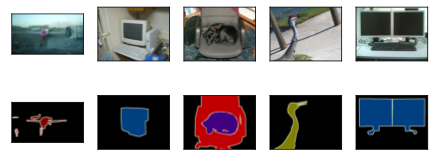

In [30]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [31]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [32]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

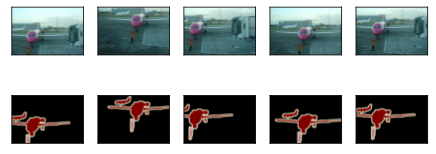

In [33]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [34]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [35]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [36]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [37]:
#@save
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

## Fully Convolutional Networks

![fcn.svg](./images/8/fcn.svg)

- Here we describe the basic design of the fully convolutional network model. As shown, this model first uses a CNN to extract image features, then transforms the number of channels into the number of classes via a $1\times 1$ convolutional layer, and finally transforms the height and width of the feature maps to those of the input image via the transposed convolution

In [38]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [39]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [40]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

### Initializing Transposed Convolutional Layers

- We already know that transposed convolutional layers can increase the height and width of feature maps. In image processing, we may need to scale up an image, i.e., upsampling. Bilinear interpolation is one of the commonly used upsampling techniques. It is also often used for initializing transposed convolutional layers.

In [41]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [42]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

### Reading the Dataset and Training

In [43]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.416, train acc 0.870, test acc 0.855
258.1 examples/sec on [device(type='cuda', index=0)]


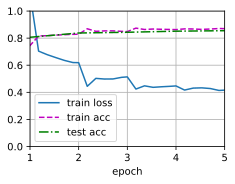

In [44]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### Prediction

In [45]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

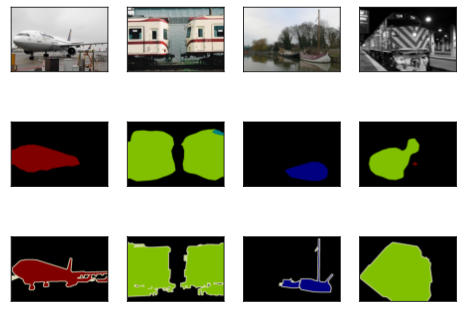

In [46]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);